This notebook was made to compare surface current within different stations in the Fraser River

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from glob import glob
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

In [3]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  500,
        'j':367
    },


        }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '16', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '14'}

In [4]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    }

In [5]:
def ebb_tide_time(grid_T, stn_name, PST , MSL = 0):
    "Determine ebb tide start time and end time in PST or UTC at\
    a given day at stations we got our tidal preditions"
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    for i in np.arange(len(ttide)):
        
        if (ttide.time[i].year == t_orig.year) & (ttide.time[i].month == t_orig.month)\
        & (ttide.time[i].day == t_orig.day):
            if (ssh[i] - ssh[i-1] >0) & (ssh[i] - ssh[i+1] >0):
                ebb_tide_start = ttide.time[i].hour
            
            if (ssh[i] - ssh[i-1] <0) & (ssh[i] - ssh[i+1] <0): 
                ebb_tide_end = ttide.time[i].hour
    if PST ==0:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " UTC time"
    else:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " PST time"
    return ebb_tide_start, ebb_tide_end  

In [6]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [7]:
run_date = datetime.datetime(2015,6,15)
# new results dataset location
results_home_now = '/ocean/jieliu/research/meopar/river-treatment/24hrs_test/'
results_dir_now = os.path.join(results_home_now, run_date.strftime('%d%b%y').lower())

In [8]:
grid_T = results_dataset('1h', 'grid_T', results_dir_now)
grid_U_now = results_dataset('1h', 'grid_U', results_dir_now)
grid_V_now = results_dataset('1h', 'grid_V', results_dir_now)

In [9]:
## currents for straight river channel
u_now = grid_U_now.variables['vozocrtx']
v_now = grid_V_now.variables['vomecrty']
hours = grid_U_now.variables['time_counter']
hour = hours[:]/3600

In [10]:
start, end = ebb_tide_time(grid_T, 'Point Atkinson', PST = 0, MSL = 0)

ebb tide begins at 11, ends at 19 UTC time


In [11]:
def compare_surfacecurrent_at_stns(grid_T, PST,m, u_now,v_now, start, end):
    '''This function was made to compare surface currents at different 
        Fraser River stations during a day'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    names = ['Sandheads', 'Deas Island', 'New Westminster', 'Mission']
    ylims = [-2,1]
    ax = axs[0]
    for name, M in zip(names,m):
        u_now_st = u_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(hour, u_now_st, linewidth=2, label=name)
        ax.grid('on')
        #x.plot( start, ylims,'-r', lw=2)
        #x.plot(end,ylims, '-r', lw=2)
        ax.set_xlim([0, 24])
        ticks = range(24)
        ax.set_xticks(ticks, minor = False)
        ax.set_xticklabels(ticks)
        ax.set_ylim([-2,1])
        ax.set_title(
            'Hourly Surface Current at Fraser River stations: {t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_ylabel('zonal surface current u (m/s)', **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')

    ax = axs[1]
    for name, M in zip(names,m):
        v_now_st = v_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(hour, v_now_st, linewidth=2, label=name)
        ax.grid('on')
        ax.set_xlim([0, 24])
        ticks = range(24)
        ax.set_xticks(ticks, minor = False)
        ax.set_xticklabels(ticks)
        ax.set_ylim([-2,1])
        ax.set_title(
            'Hourly Surface Current at Fraser River stations: {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_ylabel('meridional surface current v (m/s)', **axis_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')
    return fig   

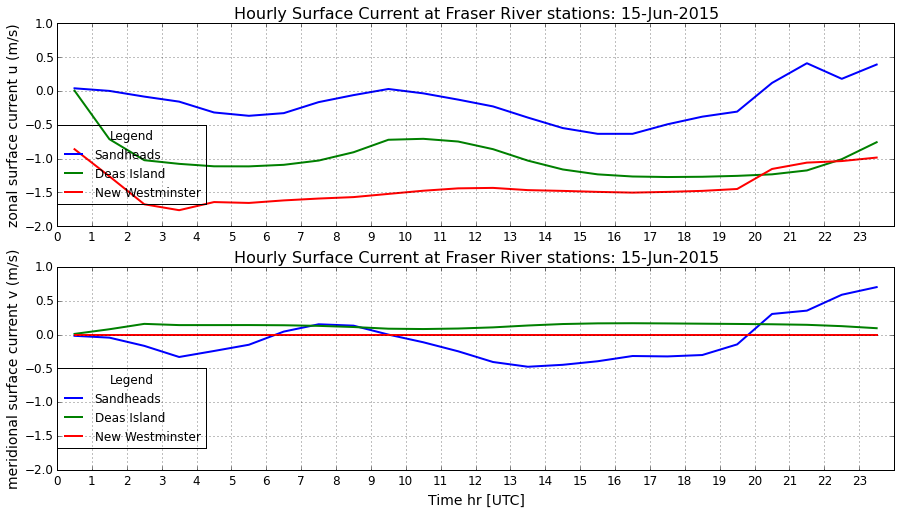

In [12]:
fig = compare_surfacecurrent_at_stns(grid_T, 0, range(3), u_now, v_now, start, end)

1 U velocity of Sandheads is towards SoG during ebb tide between 11 to 19 utc, V is negative which indicates the flow direction of surface currents at Sandheads during ebb tide is southwest, carrying freshwater to the south.

2 Magnitude of U velocity at New West is mostly larger than Deas Island.

3 Magnitude of V velocity at New West is zero as only single grid cell.

Surface currents for north extended not to Howe river channel

In [13]:
## surface currents for north extended river channel not to Howe
results_home= '/ocean/jieliu/research/meopar/river-treatment/24hrs_norles/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_T_nor = results_dataset('1h', 'grid_T', results_dir)
grid_U_nor = results_dataset('1h', 'grid_U', results_dir)
grid_V_nor = results_dataset('1h', 'grid_V', results_dir)
u_nor = grid_U_nor.variables['vozocrtx']
v_nor = grid_V_nor.variables['vomecrty']

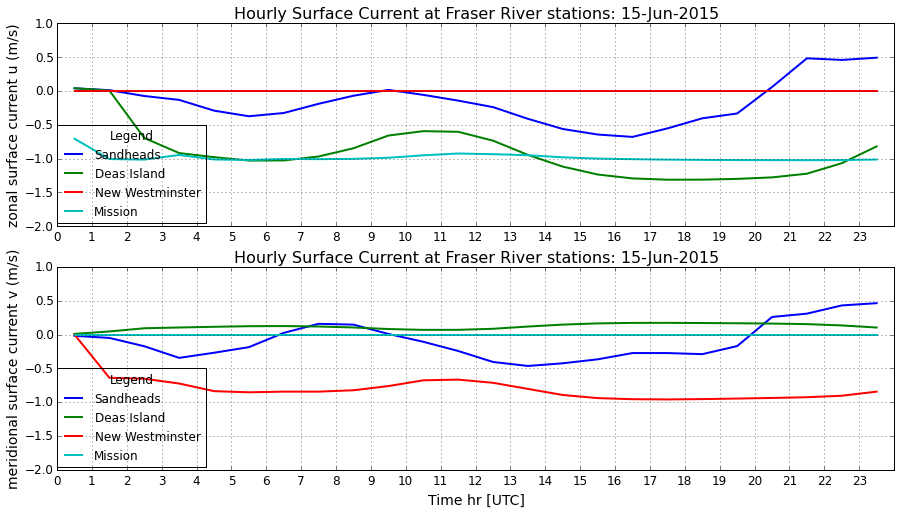

In [14]:
figg = compare_surfacecurrent_at_stns(grid_T_nor, 0, range(4), u_nor, v_nor, start, end)

1 Magnitude of U at Mission is smaller than New West with straight river channel.

2 U & V at Sandheads look the same with those with straight river channel.

mean surface current for north channel after 14 days run

In [15]:
## surface currents for north extended river channel after 14 days run 
results_home= '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/'
run_date = datetime.datetime(2015,6,16)
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_T_14nor = results_dataset('1h', 'grid_T', results_dir)
grid_U_14nor = results_dataset('1h', 'grid_U', results_dir)
grid_V_14nor = results_dataset('1h', 'grid_V', results_dir)
u_14nor = grid_U_14nor.variables['vozocrtx']
v_14nor = grid_V_14nor.variables['vomecrty']

In [16]:
## accumlate corresponding hour of each day and add them up comment on right now
##uu = np.zeros((((24, 40, 898, 398))))
##vv = np.zeros((((24, 40, 898, 398))))
##for k in range(24):
    ##for i in range(7):
        ##j = 24 * i +k
        ##uu[k, :, :, :] = uu[k, :, :, :] + u_7nor[j, :, :, :] 
        ##vv[k, :, :, :] = vv[k, :, :, :] + v_7nor[j, :, :, :]

In [17]:
##uu_mean_7nor = np.empty_like(uu)
##vv_mean_7nor = np.empty_like(vv)
##for i in range(7):
    ##uu_mean_7nor[i,:,:,:] = uu[i, :, :, :]/7
    ##vv_mean_7nor[i,:,:,:] = vv[i, :, :, :]/7

surface current for north channel after 14 days run

In [18]:
def compare_surfacecurrent_at_stns_diffdays(grid_T, PST,m, u_now,v_now, start, end):
    '''This function was made to compare surface currents at different 
        Fraser River stations during a time period'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    names = ['Sandheads', 'Deas Island', 'New Westminster', 'Mission']
    ylims = [-2,1]
    ax = axs[0]
    for name, M in zip(names,m):
        u_now_st = u_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(t[:] + time_shift * PST, u_now_st, linewidth = 2, label = name)
        ax.grid('on')
        ax.set_xlim(t_orig + time_shift * PST, t_final + time_shift * PST)
        ax.set_ylim([-2,1])
        ax.set_title(
        'Daily Surface Current at Fraser River stations from {t_orig:%d-%b-%Y} to {t_final:%d-%b-%Y}'
            .format( t_orig=t_orig, t_final = t_final),
            **title_font)
        ax.set_ylabel('zonal surface current u (m/s)', **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')

    ax = axs[1]
    for name, M in zip(names,m):
        v_now_st = v_now[:, 0, sites[name]['i'], sites[name]['j']]
        ax.plot(t[:] + time_shift * PST, v_now_st,linewidth = 2, label = name)
        ax.grid('on')
        ax.set_xlim(t_orig + time_shift * PST, t_final + time_shift * PST)
        ax.set_ylim([-2,1])
        ax.set_title(
        'Daily Surface Current at Fraser River stations from {t_orig:%d-%b-%Y} to {t_final:%d-%b-%Y}'
            .format(t_orig = t_orig, t_final = t_final),
                **title_font)
        ax.set_ylabel('meridional surface current v (m/s)', **axis_font)
        ax.set_xlabel('Time day {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    legend = ax.legend(
                bbox_to_anchor=(0.,0.5), loc=2, borderaxespad=0.,
                prop={'size': 12}, title=r'Legend')
    legend.get_title().set_fontsize('12')
    return fig   

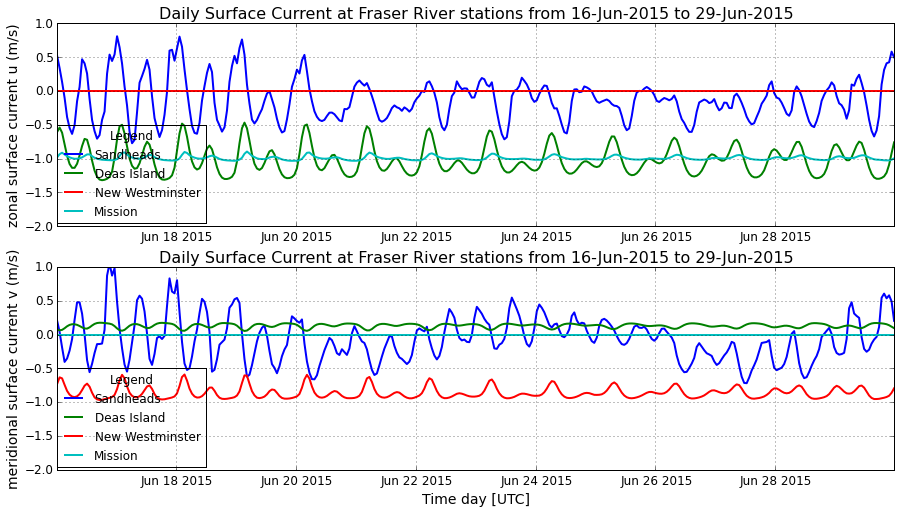

In [19]:
figg = compare_surfacecurrent_at_stns_diffdays(grid_T_14nor, 0, range(4), u_14nor, v_14nor, start, end)

* U, V velocity at Sandheads are mostly in the postive direction at the same time or negative, which means plume will go south during ebb tide. Maximum magnitude of U exceeds 0.5m/s. 